In [1]:
import copy
from enum import Enum
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from mimt import *

mi.set_variant("cuda_ad_rgb")

class Setting(Enum):
    Direct = 1
    VaryingBRDF = 2
    IndirectIllumination = 3

In [2]:
def create_scene(setting: Setting, integrator: str):
    texture = create_gradient_image(32, 32, color_1=[1, 0, 0], color_2=[0, 1, 0])
    texture[:, :, 2] = 0.05

    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": 2,
            "hide_emitters": False,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0, 0,  0],
                target = [0, 0, -1],
                up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 128,
                "height": 128,
                "sample_border": True,
            },
            "sampler": { "type": "stratified", "sample_count": 529, },
        },

        "surface_1": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0,  0, -1],
                target = [0, -1,  0],
                up=[0, 1, 0]
            ).scale(0.75),
        },

        "surface_2": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0, -2, -1],
                target = [0, 0,  -1],
                up=[0, 0, 1]
            ).scale(0.75),
            "emitter": { 
                "type": "area",
                "radiance": {
                    'type': 'bitmap',
                    'data': 2*texture,
                    'raw': True
                },
            }
        },
    }

    if setting == Setting.Direct:
        # Make the first surface an emitter and remove the second surface
        scene_dict["surface_1"]["emitter"] = scene_dict["surface_2"]["emitter"]
        del scene_dict["surface_2"]
    elif setting == Setting.VaryingBRDF:
        scene_dict["surface_1"]["bsdf"] = {
            "type": "diffuse",
            'reflectance': {
                'type': 'bitmap',
                'data': texture,
                'raw': True
            }
        }
        scene_dict["surface_2"]["emitter"]["radiance"] = {
            'type': 'rgb',
            'value': 10.0,
        }

    return scene_dict
    # scene_dict_overview = scene_dict.copy()
    # scene_dict_overview["sensor"] = scene_dict["sensor"].copy()
    # scene_dict_overview["sensor"]["to_world"] = mi.ScalarTransform4f.look_at(
    #     origin=[4, 4, 4], target=[0, 0, 0], up=[0, 1, 0]
    # )

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['surface_1.to_world'] = mi.Transform4f.translate([0, 0, -offset]) @ original
    params.update()
    return params

def compute_gradient_finite_differences(func: callable, x: float, h: float = 0.01):
    return (func(x + h) - func(x - h)) / (2*h)

def compute_gradient_forward(func: callable, x: float):
    x_attached = mi.Float(x)
    dr.enable_grad(x_attached)

    output = func(x_attached)

    dr.set_grad(x_attached, 1)
    dr.forward_from(x_attached)
    return dr.grad(output)

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3716369..0.5405319].


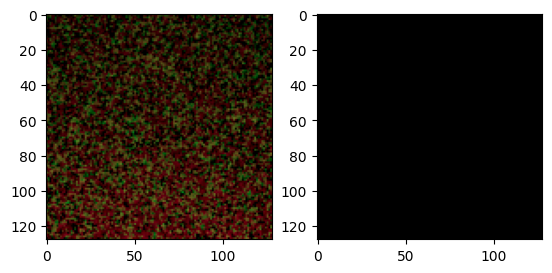

In [3]:
data = {}

settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination]
integrators = ["path", "prb", "prb_basic"]

for setting in tqdm(settings):
    data[setting] = []

    for integrator in tqdm(integrators, leave=False):
        scene = mi.load_dict(create_scene(setting, integrator=integrator))

        params   = mi.traverse(scene)
        original = mi.Transform4f(params['surface_1.to_world'])

        # Render primal image
        img = mi.render(scene, params=params, seed=0)

        # Compute gradients
        render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
        grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.01)
        grad_fw = compute_gradient_forward(render_with_offset, 0.)

        data[setting].append((integrator, img, grad_fd, grad_fw))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mi.Bitmap(grad_fd).convert(srgb_gamma=True))
axs[1].imshow(mi.Bitmap(grad_fw).convert(srgb_gamma=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.34918964..1.3077365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.966265..0.9303705].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.961562..0.9301602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.961549..0.9301598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.961551..0.9301598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21715023..1.2394446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.970417

path path
prb prb
prb_basic prb_basic
path path
prb prb
prb_basic prb_basic
path path
prb prb
prb_basic prb_basic


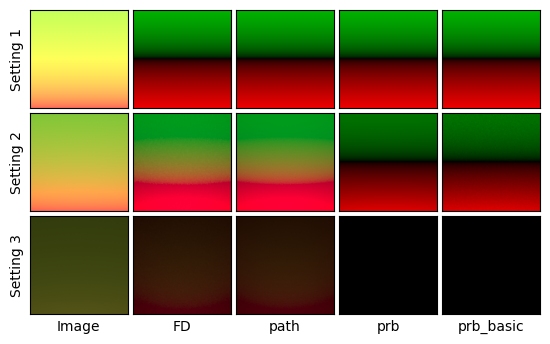

In [13]:
n_rows = len(settings)
n_cols = 2 + len(integrators)

linewidth    = 237.13594/71.959
figure_width = 2*linewidth
aspect       = (n_rows / n_cols)
fig = plt.figure(1, figsize=(figure_width, aspect * figure_width), constrained_layout=False)
gs  = fig.add_gridspec(n_rows, n_cols, wspace=0.05, hspace=0.05)

for i, setting in enumerate(settings):
    setting_data = data[setting]
    for j, integrator in enumerate(integrators):
        print(setting_data[j][0], integrator)
        assert setting_data[j][0] == integrator
        if j == 0:
            # Show primal image
            ax_img = fig.add_subplot(gs[i, j])
            ax_img.imshow(mi.Bitmap(setting_data[j][1]).convert(srgb_gamma=True))
            disable_ticks(ax_img)
            
            # Show FD of reference primal image
            ax_fd = fig.add_subplot(gs[i, j + 1])
            ax_fd.imshow(mi.Bitmap(setting_data[j][2]).convert(srgb_gamma=True))
            disable_ticks(ax_fd)

            if i == len(settings) - 1:
                ax_img.set_xlabel("Image")
                ax_fd.set_xlabel("FD")
            
            ax_img.set_ylabel(f"Setting {i+1}")

        # Show forward-mode gradient
        ax_fw = fig.add_subplot(gs[i, j + 2])
        ax_fw.imshow(mi.Bitmap(setting_data[j][3]).convert(srgb_gamma=True))
        disable_ticks(ax_fw)

        if i == len(settings) - 1:
            ax_fw.set_xlabel(f"{integrator}")

plt.show()

output_dir = Path("output")
output_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(output_dir / f"case_1.pdf", facecolor='white', bbox_inches='tight')